In [ ]:
!pip install tensorflow opencv-python numpy matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_root = "/content/drive/MyDrive/datasetfinal/archive"

train_images_path = os.path.join(dataset_root, "train")
val_images_path = os.path.join(dataset_root, "val")
test_images_path = os.path.join(dataset_root, "test")

train_annotations_path = os.path.join(train_images_path, "COCO_mul_train_annos.json")
val_annotations_path = os.path.join(val_images_path, "COCO_mul_val_annos.json")


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import shutil # Importing the shutil module

def create_class_dirs(output_dir, categories):
    for category in categories:
        os.makedirs(os.path.join(output_dir, category), exist_ok=True)

def organize_images(json_path, images_path, output_dir):
    with open(json_path, "r") as f:
        coco_data = json.load(f)

    category_map = {category["id"]: category["name"] for category in coco_data["categories"]}
    create_class_dirs(output_dir, category_map.values())

    for annotation in coco_data["annotations"]:
        image_id = annotation["image_id"]
        category_id = annotation["category_id"]
        image_info = next((img for img in coco_data["images"] if img["id"] == image_id), None)

        if image_info:
            image_filename = image_info["file_name"]
            src_path = os.path.join(images_path, image_filename)
            dest_path = os.path.join(output_dir, category_map[category_id], image_filename)

            if os.path.exists(src_path):
                shutil.copy(src_path, dest_path)

sorted_train_dir = os.path.join(dataset_root, "sorted_train")
sorted_val_dir = os.path.join(dataset_root, "sorted_val")

organize_images(train_annotations_path, train_images_path, sorted_train_dir)
organize_images(val_annotations_path, val_images_path, sorted_val_dir)

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.3,
                                   horizontal_flip=True, width_shift_range=0.3, height_shift_range=0.3)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(sorted_train_dir, target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(sorted_val_dir, target_size=IMAGE_SIZE,
                                                batch_size=BATCH_SIZE, class_mode='categorical')

class_names = list(train_generator.class_indices.keys())
print("✅ Class Labels:", class_names)


Found 158 images belonging to 5 classes.
Found 35 images belonging to 5 classes.
✅ Class Labels: ['door', 'front_bumper', 'headlamp', 'hood', 'rear_bumper']


In [ ]:
from tensorflow.keras.applications import ResNet50

# Load Pretrained Faster R-CNN Model with ResNet50
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze base model layers to use pretrained weights
base_model.trainable = True  # Fine-tuning enabled

# Build Faster R-CNN Model with ResNet50
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy", metrics=["accuracy"])

print("✅ Faster R-CNN with ResNet50 is ready!")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Faster R-CNN with ResNet50 is ready!


In [ ]:
EPOCHS = 20

history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Save Model
model.save("/content/drive/MyDrive/damage_detection_faster_rcnn.h5")
print("✅ Faster R-CNN Model saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 203s 15s/step - accuracy: 0.2398 - loss: 1.8103 - val_accuracy: 0.2857 - val_loss: 1.9001
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 188s 13s/step - accuracy: 0.2687 - loss: 1.6167 - val_accuracy: 0.2857 - val_loss: 1.9536
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - accuracy: 0.3132 - loss: 1.5995 - val_accuracy: 0.1429 - val_loss: 2.3174
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 14s/step - accuracy: 0.3410 - loss: 1.4847 - val_accuracy: 0.1429 - val_loss: 1.8863
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 191s 13s/step - accuracy: 0.3513 - loss: 1.4179 - val_accuracy: 0.2857 - val_loss: 2.6389
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 131s 13s/step - accuracy: 0.4284 - loss: 1.3417 - val_accuracy: 0.2857 - val_loss: 3.5748
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 134s 13s/step - accuracy: 0.3207 - loss: 1.4984 - val_accuracy: 0.2857 - val_loss: 4.5242
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 135s 13s/step - accuracy: 0.3833 - loss: 1.3567 - val_accuracy: 0.

✅ Faster R-CNN Model saved successfully!


In [ ]:
# Get true labels
y_true = val_generator.classes

# Get predictions
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average="weighted")
recall = recall_score(y_true, y_pred_classes, average="weighted")
f1 = f1_score(y_true, y_pred_classes, average="weighted")

# Print results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Classification report
print("\n🔍 Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("\n📊 Confusion Matrix:\n", cm)


3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step
✅ Accuracy: 0.2857
✅ Precision: 0.1372
✅ Recall: 0.2857
✅ F1 Score: 0.1795

🔍 Classification Report:
               precision    recall  f1-score   support

        door       0.00      0.00      0.00         9
front_bumper       0.00      0.00      0.00         6
    headlamp       0.38      0.60      0.46        10
        hood       0.00      0.00      0.00         5
 rear_bumper       0.21      0.80      0.33         5

    accuracy                           0.29        35
   macro avg       0.12      0.28      0.16        35
weighted avg       0.14      0.29      0.18        35


📊 Confusion Matrix:
 [[0 0 6 0 3]
 [0 0 1 0 5]
 [0 0 6 0 4]
 [0 0 2 0 3]
 [0 0 1 0 4]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average="weighted")
recall = recall_score(y_true, y_pred_classes, average="weighted")
f1 = f1_score(y_true, y_pred_classes, average="weighted")

# Print results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")


✅ Accuracy: 0.2857
✅ Precision: 0.1372
✅ Recall: 0.2857
✅ F1 Score: 0.1795


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


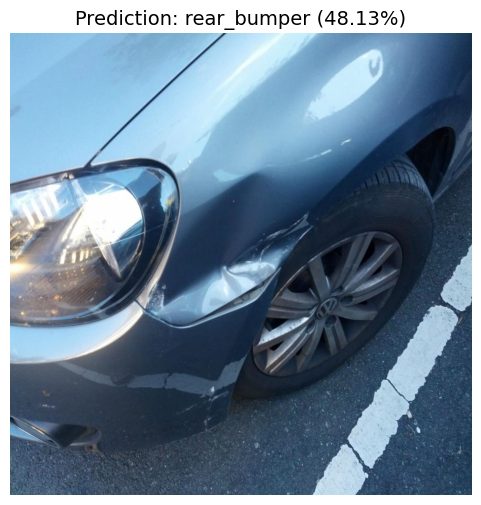

In [ ]:
def predict_damage(image_path):
    model = tf.keras.models.load_model("/content/drive/MyDrive/damage_detection_faster_rcnn.h5")

    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (224, 224))
    image_array = np.expand_dims(image_resized / 255.0, axis=0)

    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_names[predicted_class]
    confidence = prediction[0][predicted_class] * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)", fontsize=14)
    plt.axis("off")
    plt.show()

# Example usage
predict_damage("/content/drive/MyDrive/datasetfinal/archive/test/60.jpg")
